# Initialization

In [1]:
#Used in transformer network
!pip install einops

In [2]:
import io
import json
import os

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import math

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from einops import rearrange

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import random

import copy

import seaborn as sns
%pylab inline

##Ignoring warnings for now
import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
%%capture
!pip install pandas matplotlib google-cloud-storage

import os
from google.colab import drive
drive.mount('/content/drive')

# Point environment variable `GOOGLE_APPLICATION_CREDENTIALS` to 
# location of service account file 'dtu-course-02456-students.json'.
#os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/content/drive/My Drive/Woodsense/Tech/Software/Deep Learning Course DTU/Students Folder/gcp-service-accounts/dtu-course-02456-students.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS']  = "/content/drive/My Drive/Colab Notebooks/02456-deep-learning-with-PyTorch/WoodSense/gcp-service-accounts/dtu-course-02456-students.json"

# Defining functions for preprocessing

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def clean_up_weather(df):
  """
  Cleans up weather data by using interpolation. All data points that are null after interpolation
  are removed. 

  Input:
  df(Dataframe): Dataframe holding Woodsense data

  Returns:
  df(Dataframe): Cleaned dataframe without NaN values. 
  """

  indexes = []
  tmp_new = pd.DataFrame()
  n, i, no = 0,0,0
  for sensors in df['sensor_id'].unique():
    #print(sensors)
    cur_sens = df[df['sensor_id'] == sensors]
    if pd.isnull(cur_sens['weather_humidity']).sum() > (len(cur_sens)/2):
      n += 1
      #print('To many nulls: ', sensors)
      pass
    elif pd.isnull(cur_sens['weather_humidity']).sum() != 0:
      i += 1
      #print('Interpolation for ', sensors)
      mask = df["sensor_id"] == sensors
      tmp_df = df[mask].set_index('timestamp').interpolate(method='time').reset_index()
      tmp_new = pd.concat([tmp_new, tmp_df])
    else:
      no += 1
      #print('No nulls', sensors)
      mask = df["sensor_id"] == sensors
      tmp_new = pd.concat([tmp_new,df[mask]])
  tmp_new = tmp_new.dropna()
  #print('To many nulls in total: ',n)
  #print('Interpolations in total: ',i)
  #print('No nulls: ',no)
  return tmp_new

In [6]:
def load_data(date,drop_primary_nans = True,drop_weather_nans=False):
  """
  Loads the sensor data and remove NaN values if chosen so.

  Parameters:
  date (str): date of the WoodSense data given in format YYYY-mm-dd
  drop_primary_nans (bool): Drop all rows where there is NaN in timestamp, temperature, humidity, ohms and moisture columns
  drop_temperature_nans (bool): Drop alle rows if NaN where there is weather data

  Returns:
  df(Dataframe): Dataframe holding Woodsense data. 

  """
  df = pd.read_csv('/content/drive/My Drive/WoodSense/data/woodsense-sensor-data-' + date + '.csv')
  df.timestamp = pd.to_datetime(df.timestamp,infer_datetime_format=True,errors='coerce')
  #df = df.sort_values(by=['timestamp'])
  df = df.drop(columns=['weather_wind_min','ohms'])
  if drop_primary_nans:
    df = df.dropna(subset=['timestamp','temperature','humidity','moisture'])
  if drop_weather_nans:
    df = df.dropna(subset = ['weather_humidity','weather_pressure','weather_temp_dew','weather_temp_dry',
                        'weather_wind_dir','weather_wind_speed','weather_wind_max','weather_precip_past10min'])
  #df=df[df.sensor_id!=51]
  return df

In [7]:
def feature_extract_time_(df):
  """
  Makes features extraction from timestamp in dataframe. 

  Input:
  df(Dataframe): Dataframe holding timestamp per sample

  Returns:
  df(Dataframe): Dataframe with time features
  """
  df['tod_sin'] = np.sin(df['timestamp'].dt.hour / 24 * 2 * np.pi)
  df['tod_cos'] = np.cos(df['timestamp'].dt.hour / 24 * 2 * np.pi)
  df['doy_sin'] = np.sin(df['timestamp'].dt.dayofyear / 365 * 2 * np.pi)
  df['doy_cos'] = np.cos(df['timestamp'].dt.dayofyear / 365 * 2 * np.pi)

  return df

In [8]:
def create_model_eval_set(df,test_sensors = [20, 25, 26, 27, 50, 51],random_sensors = False):
  """
  Sets sensors with known anomalities aside for model comparison. Can also set random sensors aside. 

  Input:
  df (Dataframe): Dataframe to remove sensors from
  test_sensors(list): List of tensors to be set aside. Overrided if random_sensors = True
  random_sensors(bool): If True sets random sensors aside for model comparison

  Returns:
  df(Dataframe): Dataframe without the chosen sensors
  """

  if random_sensors:
    sensors = df.sensor_id.unique()
    random.seed(42)
    test_sensors = random.sample(sensors,10)
    # random.choice(sensors,size=10,replace=False)
    
  mask = df.sensor_id.isin(test_sensors)
  df_model_eval = df[mask].copy()

  #df_model_eval.to_csv('/content/drive/MyDrive/WoodSense/notebooks/Final models and comparison/[name].csv',sep=';',index=False)
  df = df[~mask].copy()
  return df

In [9]:
def standardise(data,mean_and_stds=None):
  """
  Standardises each feature in the data. 
  If mean_and_stds is None it standardises based on the statistics in the data and otherwise standardises on the mean_and_stds dataframe.  

  Parameters:
  data (DataFrame): Data object to standardize. Columns must not contain timestamps or strings.

  """

  if mean_and_stds is None:

    mean_and_stds = pd.DataFrame()
    measures = []
    means = []
    stds = []
    
    for col in data.columns: 
      if col not in ['timestamp','sensor_id','tod_sin','tod_cos','doy_sin','doy_cos']:
        mean = data[col].mean()
        std = data[col].std()

        measures += [col]
        means += [mean]
        stds += [std]
        data.loc[:,col] = (data[col]-mean)/std

    mean_and_stds['measure'] = measures
    mean_and_stds['mean'] = means
    mean_and_stds['std'] = stds
  
  else: 

    for m in mean_and_stds['measure'].unique():
      mean = mean_and_stds.loc[mean_and_stds['measure'] == m, 'mean'].to_numpy()
      std = mean_and_stds.loc[mean_and_stds['measure'] == m, 'std'].to_numpy()
      data.loc[:,m] = (data.loc[:,m]- mean)/std

  return data, mean_and_stds

In [10]:
def data_split(data,sensor_based = True,test_size = 0.33):
  """
  Splits the data in a train and test where split either is based on sensors or randomly chosen time-windows. 
  
  Parameters: 
  data(DataFrame or list): Data to be split. If sensor-based split give DataFrame. If time-window based split give list. 
  sensor_based (bool): If True split is sensor based. If False split is time-window based. 
  test_size (float): The percentage of sensors or time-windows to be put aside to test set. 

  !Note. If sensor_based = False, the function will not work in relation to the other functions. 

  Returns: 
  Data splits of data, time, 


  """
  import random

  if sensor_based: 
    sensors = data.sensor_id.unique().tolist()
    n_sensors = len(sensors)

    k = int(test_size*n_sensors)
    #print(k)

    random.seed(42) #Uncomment for different splits
    #test_sensors = random.sample(sensors,k)
    test_sensors = [ 4,  5, 10, 11, 12, 34, 37, 41, 45, 52, 55, 65]
    # random.choice(sensors,size=10,replace=False)
    #print(test_sensors)

    test = data[data.sensor_id.isin(test_sensors)].copy()
    train = data[~data.sensor_id.isin(test_sensors)].copy()

    #print(test.sensor_id.unique())

    train = train.sort_values(['sensor_id','timestamp'])
    test = test.sort_values(['sensor_id','timestamp'])

    return train, test
  else: # sensor_based = False not tested yet
    data, timestamps, data_seqs, sensors = data
    train_data, test_data, train_time, test_time, train_seqs, test_seqs, train_sensors, test_sensors = train_test_split(data, timestamps, data_seqs, sensors,test_size = test_size)
    
    return train_data, test_data, train_time, test_time, train_seqs, test_seqs, train_sensors, test_sensors


In [11]:
def drop_weather(df):
  """
  Removes weather columns
  Parameters: 
  df (DataFrame): DataFrame to remove weather columns from
  """
  if df.columns.isin([ 'weather_humidity', 'weather_pressure','weather_temp_dew', 'weather_temp_dry', 'weather_wind_dir','weather_precip_past10min', 'weather_wind_max', 'weather_wind_speed']).any():
    df = df.drop(columns=[ 'weather_humidity', 'weather_pressure','weather_temp_dew', 'weather_temp_dry','weather_precip_past10min', 'weather_wind_max', 'weather_wind_speed'])

  return df

In [12]:
def create_inout_sequences_transformer(input_data, tw, target_size = 1, 
                            step_size = 1,
                            std_on_sensor=False,
                            mean_and_std = None):
  
    '''
    
    Function that generates sequences based on the chosen time-window, step-size and target-size.

    Parameters:
    input_data(df) = Dataframe holding Woodsense data
    tw (int) = timewindow/timestemp we want to look back on
    target_size (int) = How many hours we want to predict.
    step_size (int) = How many steps the window takes over the time series
    moisture = Choose moisture or ohms. If moisture = True then ohms is removed and vice versa. 
    mean_and_std(df): Dataframe to standardise data. If None then the data becomes standardised on the datas own statistics

    ! Note: 
    mean_and_std is only applicable if data is standardised with global mean and standard deviation. 

    Returns:
    train (list of torch tensors): List containing tensors of N features of length tw. train will be used as encoder input. 
    tgt (list of torch tensors): List containing tensors of N features of length target_size. tgt will be used as decoder input
    true (list of torch tensors): List containing the targets to predict of length target_size. true will be the true labels for the transformer to predict. 
    timestamps(list of numpy array): List containing numpy arrays of timestamps for each sample of length tw+target_size.
    sensor_list(list of sensors): List containing sensors. 
    mean_and_std(DataFrame): DataFrame used to standardise data. 
    features(list): List containing the features used in the data. 

    !NOTE: There is one-point overlap between train and tgt and one-point delay between tgt and true. 

    '''
    inout_seq = []
    label = []
    timestamps = []
    train = []
    tgt = []
    true = []
    sensor_list = []
    print('Number of sensors: ',len(input_data['sensor_id'].unique()))

    if std_on_sensor is False:
      data, mean_and_std = standardise(input_data,mean_and_std)

    for sensors in input_data['sensor_id'].unique():
      data = input_data.loc[input_data['sensor_id'] == sensors]

      timestamp = data.timestamp.astype(int).to_numpy()
      
      data = data.drop(columns=['timestamp'])

      first = data.iloc[0]
      last = data.iloc[-1]
      L = len(data)
      if std_on_sensor:
        data, mean_and_std = standardise(data,mean_and_std)
      data = data.drop(columns=[ 'sensor_id'])
      features = data.columns.tolist()
      data = data.astype(np.float32).to_numpy().tolist()
      data = torch.FloatTensor(data)
      for i in range(0,L-tw-target_size, step_size):

        train_seq = data[i:i+tw-1]
        tgt_seq = data[i+tw-2:i+tw-1+target_size]
        true_seq = data[i+tw-1:i+tw+target_size]

        assert train_seq[-1,2] == tgt_seq[0,2]
        assert tgt_seq[-1,2] == true_seq[-2,2]

        timestamp_seq = timestamp[i:i+tw+target_size]
        train.append(train_seq)
        tgt.append(tgt_seq)
        true.append(true_seq)
        timestamps.append(timestamp_seq)
        sensor_list += [sensors]
    return train, tgt, true, timestamps,  sensor_list, mean_and_std, features

In [13]:
class DatasetTransformer(torch.utils.data.Dataset):
  """
  Custom dataloader for transformer model
  """

  def __init__(self,data,tgt,true,timestamps,sensors):
    super(DatasetTransformer, self).__init__()

    self.data = data
    self.tgt = tgt
    self.true = true
    self.timestamps = timestamps
    #print(len(timestamps[0]))
    self.sensors = sensors

  def __len__(self):
    return len(self.data)
 
  def __getitem__(self,idx):
    d = self.data[idx]
    tgt = self.tgt[idx]
    true = self.true[idx]
    t = self.timestamps[idx]
    s = self.sensors[idx]

    return d, tgt, true, t, np.array([s])

In [14]:
def Dataloader_Creator(date, drop_primary_nans = True, 
                       drop_weather_nans = False, 
                       drop_weather_data = True,
                       feature_extract_time = True,
                       sensor_based_split = True,
                       tw = 24, step_size = 24,
                       target_size = 1,
                       batch_size=32, test_size = 0.33
                       ):
  

  """
  Creates torch train and test dataloader classes. 

  Parameters: 
  date (str): Date of dataset. 
  drop_primary_nans (bool): If True all Woodsense sensor data rows with NaN values will be removed. 
  drop_temperature_nans (bool): If True all weather data rows with NaN values will be removed. 
  drop_weather_data (bool): If True all weather columns are dropped. 
  sensor_based_split (bool): If True the train and test set will be split according to sensors and if False according to time-windows. 
  tw (int): Length of time window. 
  target_size (int): Size of target value to predict. 
  step_size (int): Distance from the start of each time-window.
  batch_size (int): Batch size
  test_size (int): Ratio size of either number of time-windows or number of sensors in affecting the size of the test set. 

  Returns:
  Loaders (tuple): Train- and test loader
  Time per batch(tuple): Time per sample per batch for train and test - only guaranteed if shuffle = False
  sensors (tuple): Sensors per batch for train and test loader - only guaranteed to work if shuffel = False
  mean_and_std(dataframe): Dataframe holding the mean and standard deviation in the training set for each feature. 
  features (list): List of features used

  """
  
  df = load_data(date = date,
                 drop_primary_nans = drop_primary_nans,
                 drop_weather_nans = drop_weather_nans)
  
  print('Sensors before cleaning: ',len(df.sensor_id.unique()))


  if drop_weather_data:
    df = drop_weather(df)
  else:
    df = clean_up_weather(df)
    print('Sensors after cleaning: ',len(df.sensor_id.unique()))

  if feature_extract_time:
    df = feature_extract_time_(df)

  # Create dataset for testing and comparing models
  df = create_model_eval_set(df,)

  train, test = data_split(df,sensor_based=sensor_based_split,test_size=test_size)

  train_data, train_tgt, train_true, train_time, train_sensors, mean_and_std, features  = create_inout_sequences_transformer(train,tw=tw,
                                                                                          step_size=step_size,
                                                                                          target_size=target_size,
                                                                                          mean_and_std = None)
  test_data, test_tgt, test_true, test_time, test_sensors, mean_and_std, features = create_inout_sequences_transformer(test,tw=tw,
                                                                                    step_size=step_size,
                                                                                    target_size=target_size,
                                                                                    mean_and_std = mean_and_std)
  
  train_data = DatasetTransformer(train_data,train_tgt,train_true,train_time,train_sensors)
  test_data = DatasetTransformer(test_data,test_tgt,test_true,test_time,test_sensors)

  train_loader = DataLoader(train_data,batch_size=batch_size, shuffle=True, num_workers=8)
  test_loader = DataLoader(test_data,batch_size=batch_size, shuffle=False, num_workers=8)


  return (train_loader,test_loader), (train_time,test_time),  (train_sensors,test_sensors), mean_and_std, features

# Data preprocessing 

In [15]:
sensor_based_split = True
drop_weather_data = False
feature_extract_time = True
test_size = 0.2
time_window = 24
target_size = 1
step_size = 1
batch_size = 128

loaders, timestamps, sensor_list, mean_and_std, features = Dataloader_Creator(date='2020-11-30-cleaned', 
                                                                              drop_primary_nans = False, 
                                                                              drop_weather_nans = False, 
                                                                              drop_weather_data = drop_weather_data,
                                                                              feature_extract_time = feature_extract_time,
                                                                              sensor_based_split = sensor_based_split,
                                                                              target_size=target_size,
                                                                              tw = time_window, 
                                                                              step_size = step_size, 
                                                                              batch_size=batch_size, 
                                                                              test_size = test_size)

Sensors before cleaning:  66
Sensors after cleaning:  66
Number of sensors:  48
Number of sensors:  12


In [16]:
train_loader, test_loader = loaders

## Test if dataloader works correctly

Checking if batch size is correct

In [17]:
batch = next(iter(train_loader))

train_batch, train_tgt_batch, train_true_batch, time_batch, sensor_batch = batch

train_batch.shape, train_tgt_batch.shape, train_true_batch.shape, time_batch.shape, sensor_batch.shape

(torch.Size([128, 23, 14]),
 torch.Size([128, 2, 14]),
 torch.Size([128, 2, 14]),
 torch.Size([128, 25]),
 torch.Size([128, 1]))

Checking if overlaps are correct

In [18]:
train_batch[1,:,2],train_tgt_batch[1,:,2], train_true_batch[1,:,2]

(tensor([-0.8561, -0.8561, -0.8561, -0.8561, -0.8561, -0.8561, -0.8561, -0.8561,
         -0.8561, -0.8561, -0.8561, -0.8561, -0.8520, -0.8479, -0.8438, -0.8397,
         -0.8356, -0.8316, -0.8316, -0.8316, -0.8316, -0.8316, -0.8316]),
 tensor([-0.8316, -0.8316]),
 tensor([-0.8316, -0.8316]))

Checking if timestamps are formatted correctly

In [19]:
pd.to_datetime(time_batch.numpy()[0])

DatetimeIndex(['2020-11-18 13:00:00', '2020-11-18 14:00:00',
               '2020-11-18 15:00:00', '2020-11-18 16:00:00',
               '2020-11-18 17:00:00', '2020-11-18 18:00:00',
               '2020-11-18 19:00:00', '2020-11-18 20:00:00',
               '2020-11-18 21:00:00', '2020-11-18 22:00:00',
               '2020-11-18 23:00:00', '2020-11-19 00:00:00',
               '2020-11-19 01:00:00', '2020-11-19 02:00:00',
               '2020-11-19 03:00:00', '2020-11-19 04:00:00',
               '2020-11-19 05:00:00', '2020-11-19 06:00:00',
               '2020-11-19 07:00:00', '2020-11-19 08:00:00',
               '2020-11-19 09:00:00', '2020-11-19 10:00:00',
               '2020-11-19 11:00:00', '2020-11-19 12:00:00',
               '2020-11-19 13:00:00'],
              dtype='datetime64[ns]', freq=None)

## Creating transformer model

In [20]:
#Create original positional encoding
#Source: https://pytorch.org/tutorials/beginner/transformer_tutorial
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [21]:
class OutlierTransformer(nn.Module):
    def __init__(self, n_features_in,n_features_out, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, 
                 max_seq_length, pos_dropout, trans_dropout,pos_encoding=True):
        super().__init__()
        self.d_model = d_model
        self.pos_encoding = pos_encoding
        self.embed_src = nn.Linear(n_features_in,d_model)
        self.embed_tgt = nn.Linear(n_features_in,d_model) 
        self.embed = nn.Linear(n_features_in,d_model)

        self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length)

        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, trans_dropout)

        self.linear_dropout = nn.Dropout(trans_dropout)

        self.fc = nn.Linear(d_model, n_features_out)

    def forward(self, src, tgt,tgt_mask=None):

        src = rearrange(src, 'n s e -> s n e')
        tgt = rearrange(tgt, 'n t e -> t n e')

        src = self.embed_src(src) * math.sqrt(self.d_model)
        tgt = self.embed_tgt(tgt) * math.sqrt(self.d_model)

        if self.pos_encoding:
          src = self.pos_enc(src)
          tgt = self.pos_enc(tgt)

        output = self.transformer(src, tgt, tgt_mask=tgt_mask)

        output = rearrange(output, 't n e -> n t e')
        self.linear_dropout(output)
        
        output = self.fc(output)
        return output

## Hyper-parameters for model

In [22]:
#Set parameters for model
max_seq_length = max(time_window-1,target_size+1) # hours in the day
d_model = 128
nhead = 2
num_encoder_layers = 1
num_decoder_layers = 1
dim_feedforward = 512
pos_dropout = 0.0
trans_dropout = 0.2

n_features_in = len(features)
n_features_out = 3 # If you wish to predict more than temperature, humidity and moisture. 

pos_encoding = True

model = OutlierTransformer(n_features_in,n_features_out, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, 
                 max_seq_length, pos_dropout, trans_dropout,
                 pos_encoding = pos_encoding)
model = model.to(device)

In [23]:
train_batch.shape, train_tgt_batch.shape

(torch.Size([128, 23, 14]), torch.Size([128, 2, 14]))

In [24]:
train_tgt_batch = train_tgt_batch#[:,:,:3]
output_test = model(train_batch.to(device),train_tgt_batch.to(device))
output_test.shape

torch.Size([128, 2, 3])

# Training

## Defining train function

In [25]:
def train_model(model, train_dataset, val_dataset, n_epochs,n_warmup=5000,
                plot_from = 10):
  """
  Function to train model. Note to predict more than 3 features function need to be changed where '<--' symbol is.

  Parameters:
  model(class): Defined transformer model to train
  train_dataset(dataloader): Train dataloader
  val_dataset(dataloader): Validation dataloader
  n_epochs(int): Number of epochs
  n_warmup(int): Number of warmup steps used in scheduled learning rate

  Returns:
  None
  """

  import copy
  from IPython.display import clear_output
  optimizer = torch.optim.Adam(model.parameters(), betas=(0.9,0.98),eps=1e-09)
  optim = ScheduledOptim(optimizer,model.d_model,n_warmup)

  criterion = nn.L1Loss(reduction='mean').to(device)
  history = dict(train=[], test=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  
  for epoch in range(1, n_epochs + 1):

    model = model.train()
    train_losses = []
    last_train_losses = []
    for batch in train_loader:
      optim.zero_grad()

      src,tgt,true_tgt,_,_ = batch

      src = src.to(device)
      tgt = tgt.to(device)
      true_tgt = true_tgt[:,:,:3].to(device) # First 3 measures as targets to predict <--

      tgt_mask = model.transformer.generate_square_subsequent_mask(tgt.size(1)).to(device)

      pred_tgt = model(src,tgt,tgt_mask)


      loss = criterion(pred_tgt, true_tgt)

      loss.backward()
      optim.step_and_update_lr()

      train_losses.append(loss.item())

    val_losses = []
    last_val_losses = []

    
    model = model.eval()
    with torch.no_grad():
      for batch in test_loader:
        src,tgt,true_tgt,_,_ = batch

        src = src.to(device)
        tgt = tgt.to(device)
        true_tgt = true_tgt[:,:,:3].to(device) # First 3 as targets to predict <--

        tgt_mask = model.transformer.generate_square_subsequent_mask(tgt.size(1)).to(device)

        pred_tgt = model(src,tgt,tgt_mask)

        loss = criterion(pred_tgt, true_tgt)
        val_losses.append(loss.item())
        

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['test'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    print(f'Current best test loss {best_loss}')

    #if epoch % 10 == 0:
    if epoch > plot_from+5:
      clear_output(wait=True)
      print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
      print(f'Current best test loss {best_loss}')

      train = history['train'][plot_from:]
      test = history['test'][plot_from:]

      n_range = list(range(plot_from,len(train)+plot_from))
      #n_range = (0,len(train))
      #print(len(n_range),len(train))
      plt.plot(n_range,train,label='train')
      plt.plot(n_range,test,label='test')
      plt.title('Train and test loss')
      plt.legend()

      plt.show()

  print(optim.n_current_steps)
  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [26]:
# Class is from https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/transformer/Optim.py
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [27]:
def save_model_all(model, save_dir, model_name, epoch):
    """
    :param model:  nn model
    :param save_dir: save model direction
    :param model_name:  model name
    :param epoch:  epoch
    :return:  None
    """
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    save_prefix = os.path.join(save_dir, model_name)
    save_path = '{}_epoch_{}.pt'.format(save_prefix, epoch)
    print("save all model to {}".format(save_path))
    output = open(save_path, mode="wb")
    torch.save(model, output)
    # torch.save(model.state_dict(), save_path)
    output.close()

## Train model

Epoch 100: train loss 0.016915527472410027 val loss 0.02424699506710893
Current best test loss 0.023584251556499503


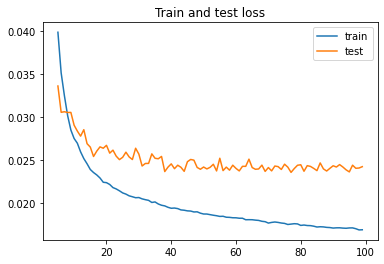

44700


In [28]:
#Train model

model, history = train_model(
  model, 
  train_loader, 
  test_loader, 
  n_epochs=100,
  plot_from=5,
  n_warmup = 2500,
)


In [29]:
#Uncomment to save model
#save_model_all(model, '/content/drive/My Drive/WoodSense/notebooks/Final models and comparison', 'Transformer_final_weather', 100)

Testing if last saved model loads properly

In [30]:
model = torch.load('/content/drive/MyDrive/WoodSense/notebooks/Final models and comparison/Transformer_final_weather_epoch_100.pt', map_location=torch.device(device))
model.eval()

OutlierTransformer(
  (embed_src): Linear(in_features=14, out_features=128, bias=True)
  (embed_tgt): Linear(in_features=14, out_features=128, bias=True)
  (embed): Linear(in_features=14, out_features=128, bias=True)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=

# Function to extract loss and prediction sequences

In [31]:
def test_loss_calculator(model,test_loader,Loss_type = 'L2'):

  """
  The function takes in the model and the validation loader (named test_loader because of old naming) and calculates either L1 or L2 loss

  Parameters:
  model(torch model): Model to evaluate
  test_loader(torch dataloader): Validation test loader
  Loss_type(str): Either L1 or L2. Everything else return an error statement. 

  Returns: 
  mean_loss(float): The mean loss
  true_seqs(numpy array): A numpy array containing the true sequence to predict
  pred_seqs(numpy array): A numpy array containing the predicted sequences
  timesteps(numpy array): An array returning the time sequences
  sensors(numpy array): An array containing the sensors that are in the validation set.

  """

  if Loss_type == 'L2':
    criterion = nn.MSELoss(reduction='mean').to(device)
  elif Loss_type == 'L1':
    criterion = nn.L1Loss(reduction='mean').to(device)
  else:
    print('Choose either L1 or L2 in Loss_type')
    return

  val_losses = []
  last_val_losses = []

  true_seqs = []
  pred_seqs = []
  timesteps = []
  sensors = []


  
  model = model.eval()
  with torch.no_grad():
    for batch in test_loader:
      src,tgt,true_tgt,time, sensor = batch

      src = src.to(device)
      tgt = tgt.to(device)
      true_tgt = true_tgt[:,-1:,:3].to(device) # First 3 as targets to predict

      tgt_mask = model.transformer.generate_square_subsequent_mask(tgt.size(1)).to(device)

      pred_tgt = model(src,tgt,tgt_mask)
      pred_tgt = pred_tgt[:,-1:,:3]

      loss = criterion(pred_tgt, true_tgt)
      #loss_last = criterion_last(pred_tgt[:,-1,:],true_tgt[:,-1,:])
      #print(loss)
      true_seqs.append(true_tgt.cpu().numpy())
      pred_seqs.append(pred_tgt.cpu().numpy())
      timesteps.append(time.numpy()[:,-1])
      sensors.append(sensor.numpy().squeeze())
      val_losses.append(loss.item())

    return np.mean(val_losses), true_seqs, pred_seqs, timesteps, sensors


In [32]:
loss, true_seqs, pred_seqs, timesteps, sensors = test_loss_calculator(model,test_loader,Loss_type='L2')

# Prediction error plots

## Functions for plotting

In [33]:
def create_dataframe(true_seqs,pred_seqs,timesteps,sensors,time_step = 4,m_type = 'moisture'):

  "Creates a dataframe holding the true and pred values for each measure as well as the chosen loses. "
  cols_start = [str(i) + ' - ' + str(i+time_step) for i in range(0,24,time_step)]
  cols = []
  for col in cols_start:
    cols += [col]*time_step

  measure_dict = {'temperature':0,'humidity':1,'moisture':2,'euclidian_all':-1}
  m_idx = measure_dict[m_type]
  if m_idx == -1:
    df = pd.DataFrame({'time-period':[],
                       'time':[],
                       'sensor':[],
                        'true_temperature':[],
                        'pred_temperature':[],
                        'true_humidity':[],
                        'pred_humidity':[],
                        'true_moisture':[],
                        'pred_moisture':[],
                        'Euclidian_distance':[]})    
  else:
    df = pd.DataFrame({'time-period':[],
                       'time':[],
                       'sensor':[],
                      'true':[],
                      'pred':[],
                      'L1Loss':[],
                      'L2Loss':[]})

  for true_batch, pred_batch, time, sensor in zip(true_seqs,pred_seqs,timesteps,sensors):

      if m_idx == -1:
        true_timestep = true_batch
        pred_timestep = pred_batch

        time_df = pd.DataFrame()
        time_df['time'] = pd.to_datetime(time)
        time_df['hour'] = time_df['time'].dt.hour

        col_timestep = [cols[i] for i in time_df['hour']]

        euclidian_distance = np.linalg.norm(true_timestep - pred_timestep,ord=2,axis=2).squeeze()

        df_tmp = pd.DataFrame({'time-period':col_timestep,
                      'time': time_df['time'],
                      'sensor':sensor,
                      'true_temperature':true_timestep[:,0,0],
                      'pred_temperature':pred_timestep[:,0,0],
                      'true_humidity':true_timestep[:,0,1],
                      'pred_humidity':pred_timestep[:,0,1],
                      'true_moisture':true_timestep[:,0,2],
                      'pred_moisture':pred_timestep[:,0,2],
                      'Euclidian_distance':euclidian_distance})
        
        df = df.append(df_tmp)
      else:
        true_timestep = true_batch[:,:,m_idx].reshape(-1)
        pred_timestep = pred_batch[:,:,m_idx].reshape(-1)

        time_df = pd.DataFrame()
        time_df['time'] = pd.to_datetime(time)
        time_df['hour'] = time_df['time'].dt.hour
        col_timestep = [cols[i] for i in time_df['hour']]

        L2_loss = (true_timestep - pred_timestep)**2
        L1_loss = np.absolute(true_timestep - pred_timestep)

        df_tmp = pd.DataFrame({'time-period':col_timestep,
                              'time':time_df['time'],
                              'sensor':sensor,
                              'true':true_timestep,
                              'pred':pred_timestep,
                              'L1Loss':L1_loss,
                              'L2Loss':L2_loss})
        
        df = df.append(df_tmp)

  return df

In [34]:
def plot_scatter(true_seqs,pred_seqs,timesteps,sensors,time_step=4,m_type='moisture',figsize=(20,10),alpha=0.8):
  """
  Function that plots the loss of the chosen measure/feature
  """
  df = create_dataframe(true_seqs,pred_seqs,timesteps,sensors,time_step,m_type)
  plt.figure(figsize=figsize)
  sns.scatterplot(data=df, x="true", y="pred", hue="time-period",alpha=alpha)
  plt.show()

In [35]:
def box_plots_per_hour(true_seqs,pred_seqs,timesteps,sensors,whis=1.5,time_step = 1,m_type = 'moisture',
                       loss='L1Loss',figsize=(20,5),ylim=0.15):
  
  """
  Function that plot boxplot for each time instance per chosen feature. 

  """

  df_per_hour = create_dataframe(true_seqs,pred_seqs,timesteps,sensors,time_step = 1,m_type = m_type)
  plt.figure(figsize=figsize)
  sns.set_style('whitegrid')
  box = sns.boxplot(data = df_per_hour,x='time-period',y=loss,whis=whis)
  box.set(ylim=(0,ylim)) 

  return df_per_hour 

## Scatter plot of predictions and true labels 

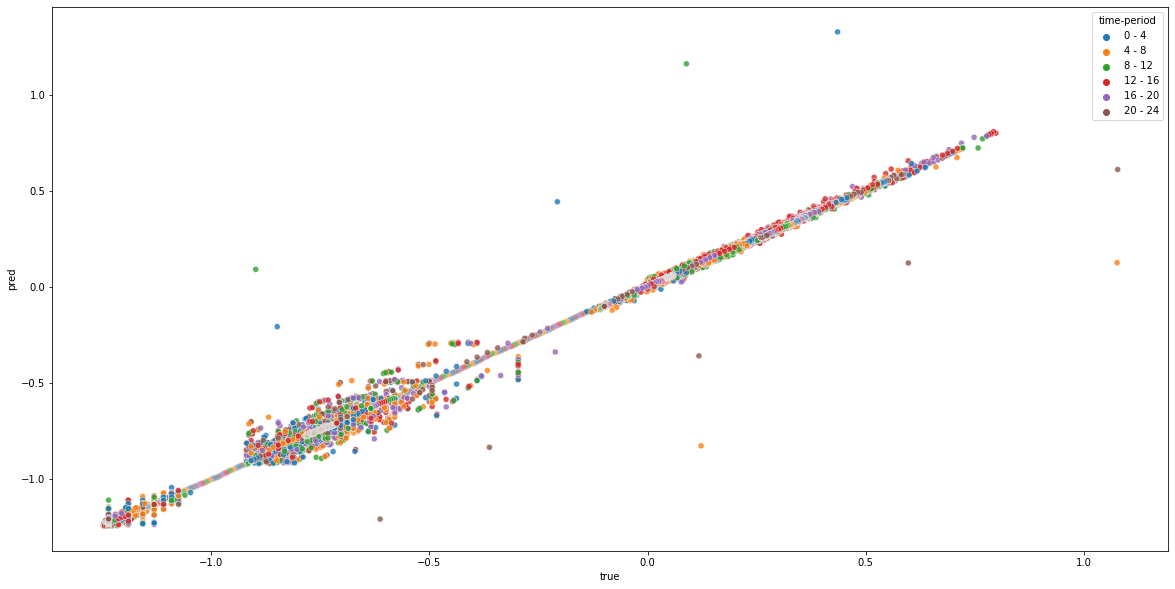

In [36]:
plot_scatter(true_seqs,pred_seqs,timesteps,sensors,time_step=4,m_type='moisture',figsize=(20,10),alpha=0.8)

## Boxplot for loss per hour

#Temperature thresholds

Section below calculates the thresholds based on the validation set which is used model comparison to see what model predicts outliers the best. 

In [37]:
df_threshold = pd.DataFrame()

Temperature threshold:  0.30232339739799496


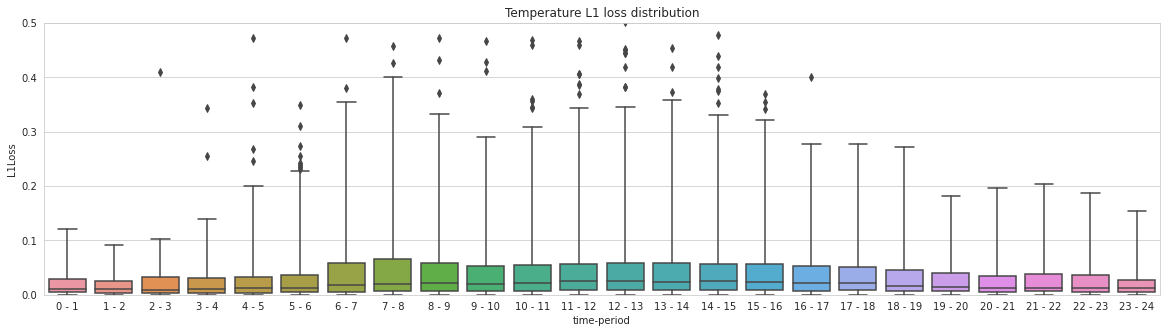

In [38]:
df_per_hour_temperature = box_plots_per_hour(true_seqs,pred_seqs,timesteps,sensors,time_step = 1,m_type = 'temperature',
                                 loss='L1Loss',figsize=(20,5),ylim=0.5,
                                 whis=6)

threshold_temperature = df_per_hour_temperature['L1Loss'].quantile(0.99)
plt.title('Temperature L1 loss distribution')

df_threshold['temperature_threshold'] = [threshold_temperature]
print('Temperature threshold: ',threshold_temperature)

Humidity threshold:  0.12799642115831367


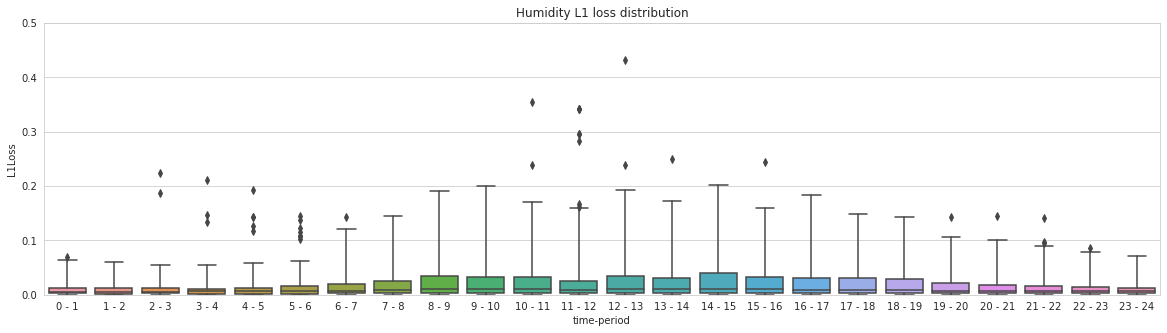

In [39]:
df_per_hour_humidity = box_plots_per_hour(true_seqs,pred_seqs,timesteps,sensors,time_step = 1,m_type = 'humidity',
                                 loss='L1Loss',figsize=(20,5),ylim=0.5,
                                 whis=6)

threshold_humidity = df_per_hour_humidity['L1Loss'].quantile(0.99)
plt.title('Humidity L1 loss distribution')

df_threshold['humidity_threshold'] = [threshold_humidity]
print('Humidity threshold: ',threshold_humidity)

Moisture threshold:  0.1244282406568525


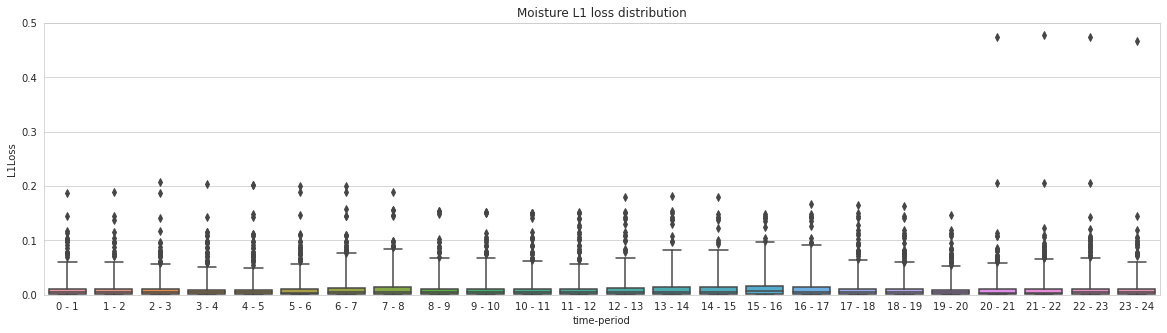

In [40]:
df_per_hour_moisture = box_plots_per_hour(true_seqs,pred_seqs,timesteps,sensors,time_step = 1,m_type = 'moisture',
                                 loss='L1Loss',figsize=(20,5),ylim=0.5,
                                 whis=6)

threshold_moisture = df_per_hour_moisture['L1Loss'].quantile(0.99)
plt.title('Moisture L1 loss distribution')

df_threshold['moisture_threshold'] = [threshold_moisture]
print('Moisture threshold: ',threshold_moisture)

Euclidian threshold:  0.33284355551004363


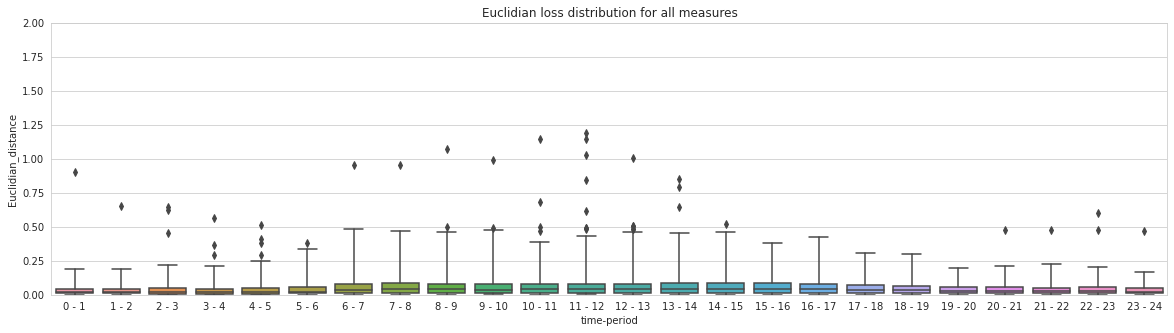

In [41]:
df_per_hour_euclidian = box_plots_per_hour(true_seqs,pred_seqs,timesteps,sensors,time_step = 1,m_type = 'euclidian_all',
                                 loss='Euclidian_distance',figsize=(20,5),ylim=2,
                                 whis=6)

threshold_euclidian = df_per_hour_euclidian['Euclidian_distance'].quantile(0.99)
plt.title('Euclidian loss distribution for all measures')

df_threshold['euclidian_threshold'] = [threshold_euclidian]
print('Euclidian threshold: ',threshold_euclidian)

In [42]:
df_threshold.index = ['Transformer']
df_threshold

,temperature_threshold,humidity_threshold,moisture_threshold,euclidian_threshold
Transformer,0.302323,0.127996,0.124428,0.332844


Saving thresholds used in model comparison

In [43]:
df_threshold.to_csv("/content/drive/MyDrive/WoodSense/notebooks/Final models and comparison/Transformer_threshold_final_weather.csv",index=False)